In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import sys

PATH ='../codes'
sys.path.insert(1,PATH)

import res_MetricLearning_JAX as mld
import DataGeneration as dg
import ML_utils as mlu

np.random.seed(1)

In [2]:
# Let us create the data

train_samp_number = 100
validation_samp_number = 100
test_samp_number = 100
t_length = 50

Output = dg.GaussianShaped(t_length=t_length, t_start=0, pmin=15, pmax=35, train_samp_number=train_samp_number,
                           validation_samp_number=validation_samp_number, test_samp_number=test_samp_number, 
                           law='linear')


def BuildNet(NL,NStart,NEnd):
    T = []
    T.append(NStart)
    N = np.floor((NStart-NEnd)/NL).astype('int')
    for r in range(NL-1):
        T.append(NStart-(r+1)*N)
    T.append(NEnd)
    return np.array(T).astype('int')

Learning stage - :   0%|          | 0/1000 [00:00<?, ?it/s]

With adam optimizer


/Users/rcarlonigert/opt/anaconda3/lib/python3.7/site-packages/jax/_src/lax/lax.py:6126: UserWarning: Explicitly requested dtype int requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  warnings.warn(msg.format(dtype, fun_name , truncated_dtype))
Learning stage - :   0%|          | 0/1000 [00:00<?, ?it/s]

With adam optimizer


Learning stage - :   0%|          | 0/1000 [00:00<?, ?it/s]

With adam optimizer


(loss=0.0626577)(loss rel. var.=0.0520698): 100%|██████████| 1000/1000 [00:34<00:00, 28.90it/s]


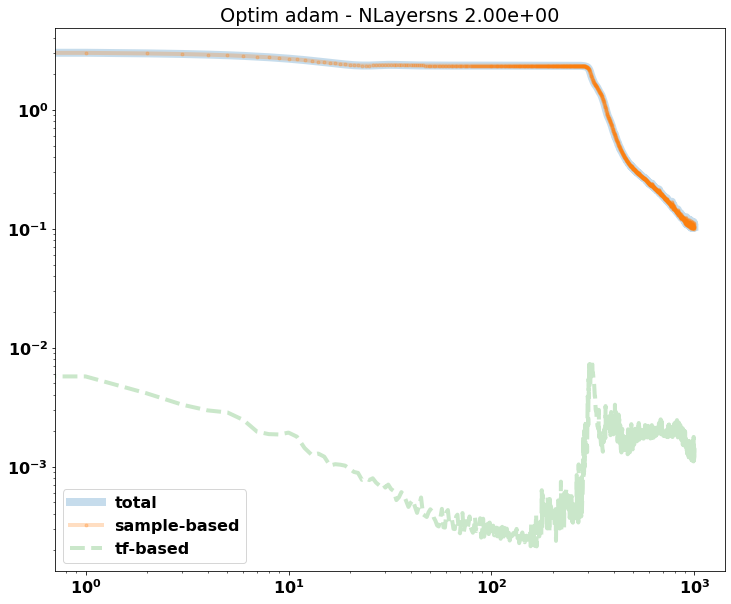

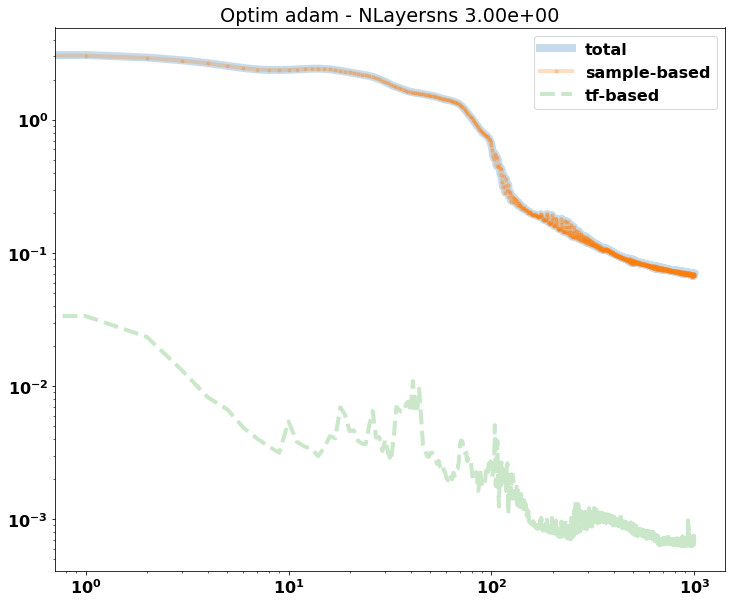

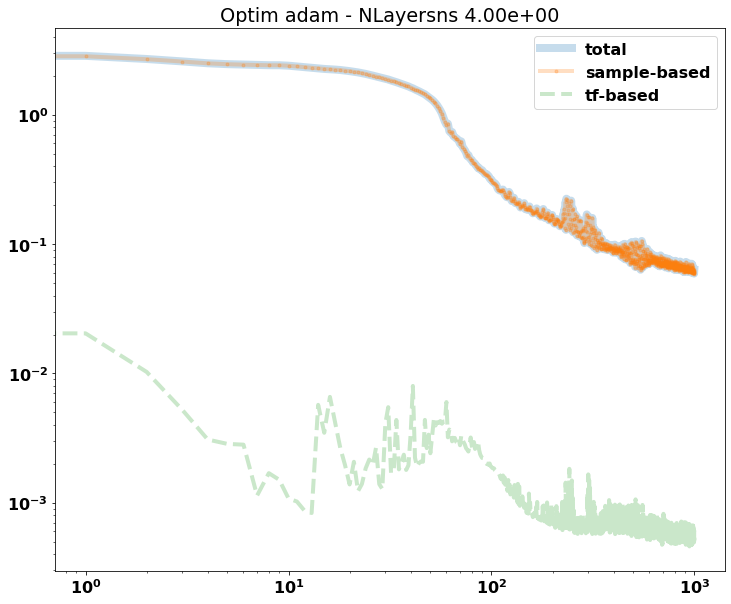

In [3]:
mu = 1
step_size = 1e-3
niter = 1000
Phi = Output["Psi"][:,[0,1]]
Optim = 0
noise_level = None

vNL = [2,3,4]

for NL in vNL:

    if NL == 2:
        out0 = None
    fname = 'model_L'+np.str(NL)
    NSize = t_length*np.ones((NL+1,),dtype='int')
    LearnFunc = mld.MetricLearning(fname=fname, noise_level=noise_level, Optim=Optim, Params=out0, simplex=True,
                                   AnchorPoints=Phi.T, NSize=NSize, step_size=step_size, reg_parameter=mu, 
                                   niter=niter, ActiveForward='lRelu', ActiveBackward='lRelu', reg_inv=1e-8, 
                                   verb=True)
    out0, outval = LearnFunc.learning_stage(Output["X_train"], Xvalidation= Output["X_valid"], batchsize=100)
    plt.figure(figsize=[12,10])
    plt.loglog(outval["total_cost"], lw=8, alpha=0.25)
    plt.loglog(outval["samp_cost"], '.-', lw=4, alpha=0.25)
    plt.loglog(outval["trans_cost"],'--', lw=4, alpha=0.25)
    plt.legend(["total","sample-based","tf-based"])
    plt.title('Optim adam - NLayersns {:.2e}'.format(NL))

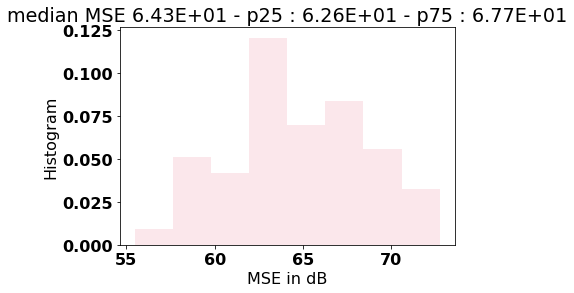

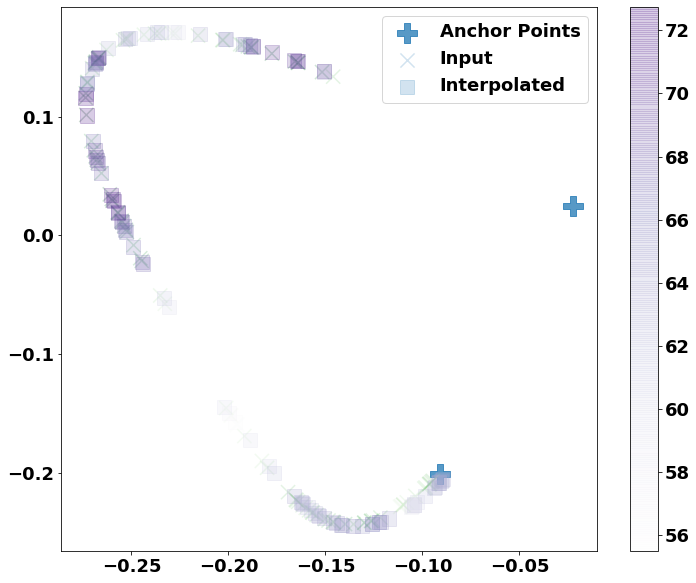

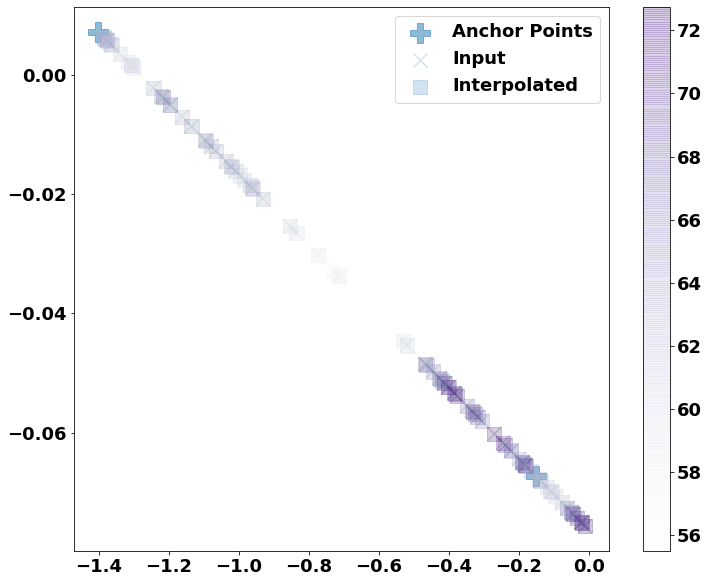

In [4]:
fname='model_L4'
out = mlu.ComparisonMetrics_BarycentricSpanProjection(Output["X_test"], fname=fname, col=1, alpha=0.1,
                                                      PlotScatter=True, savefig=True)

### Projection onto the barycentric span and robustness to noise

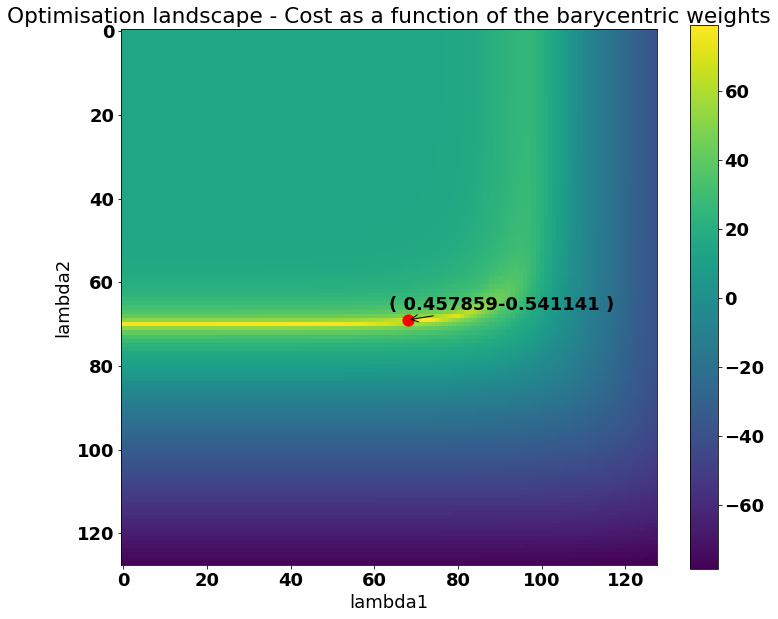

In [5]:
fname='model_L4' # MODEL
ampp = 1. # AMPLITUDE
noise_level = 0.001 # NOISE LEVEL
Xb = ampp*Output["X_test"][0:1,:] + noise_level*np.random.randn(1,50) # ADD SOME NOISE

model = mld.load_model(fname)
LearnFunc = mld.MetricLearning(Params = model)

ll = 128
t= 10**np.linspace(-3,2,ll)
error = np.zeros((ll,ll))
p1 = 0

for l1 in t:
    p2 = 0
    for l2 in t:
        Lambda = np.array([l1,l2]).reshape(1,-1)
        Xrec = LearnFunc.get_barycenter(Lambda)
        error[p1,p2]= np.linalg.norm(Xrec - Xb)**2
        p2 = p2+1
    p1 = p1+1

Outputt = LearnFunc.fast_interpolation(Xb)

def GetPointImage(Weights):
    z = abs(t - Weights[0])
    z1 = np.argwhere(z == np.min(z))[0]
    z = abs(t - Weights[1])
    z2 = np.argwhere(z == np.min(z))[0]
    return z1,z2

W = Outputt["Lambda"][0]
z1,z2 = GetPointImage(W)
plt.figure(figsize=[12,10])
plt.imshow(-20.*np.log10(error)),plt.colorbar()
plt.annotate('( '+np.str(Outputt["Lambda"][0,1])+'-'+np.str(Outputt["Lambda"][0,0])+' )', xy=(z2, z1), xycoords='data',
             xytext=(0.5, 0.5), textcoords='figure fraction',
             arrowprops=dict(arrowstyle="->"))
plt.scatter(z2, z1, s=500, c='red', marker='.')
plt.title('Optimisation landscape - Cost as a function of the barycentric weights')
plt.xlabel('lambda1')
plt.ylabel('lambda2')
plt.show()

ML (loss=9.89664e-05)(loss rel. var.=4.48467e-06):   1%|▏         | 144/10000 [00:02<02:39, 61.77it/s]


Finished in  144  it. (loss=9.89645e-05)(loss rel. var.=0)


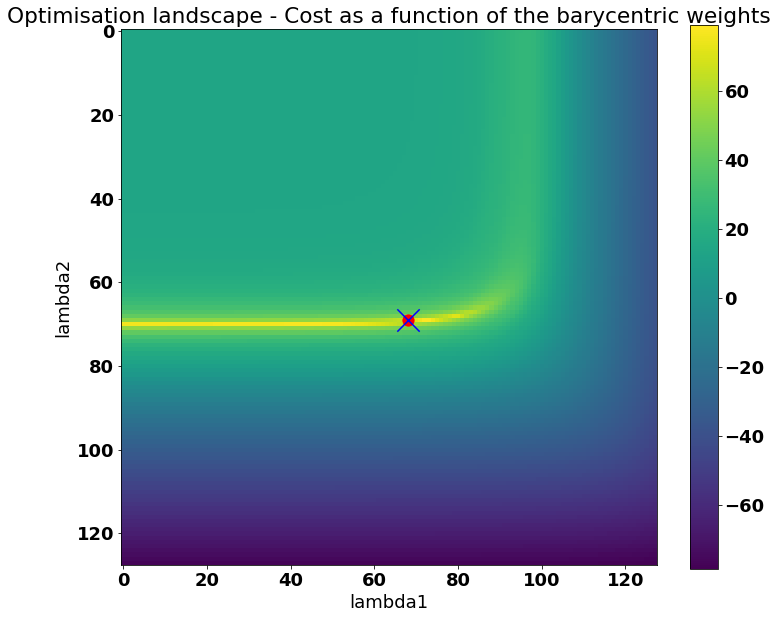

Text(0.5, 1.0, 'Residual - model_L4')

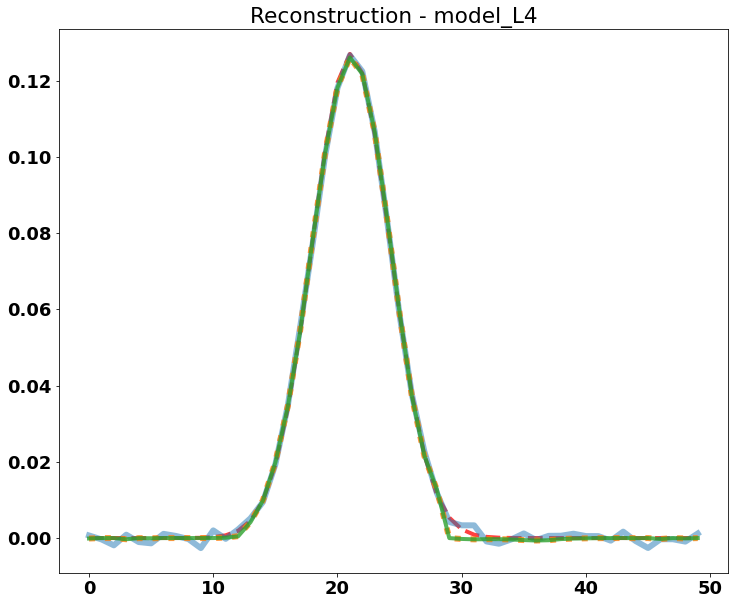

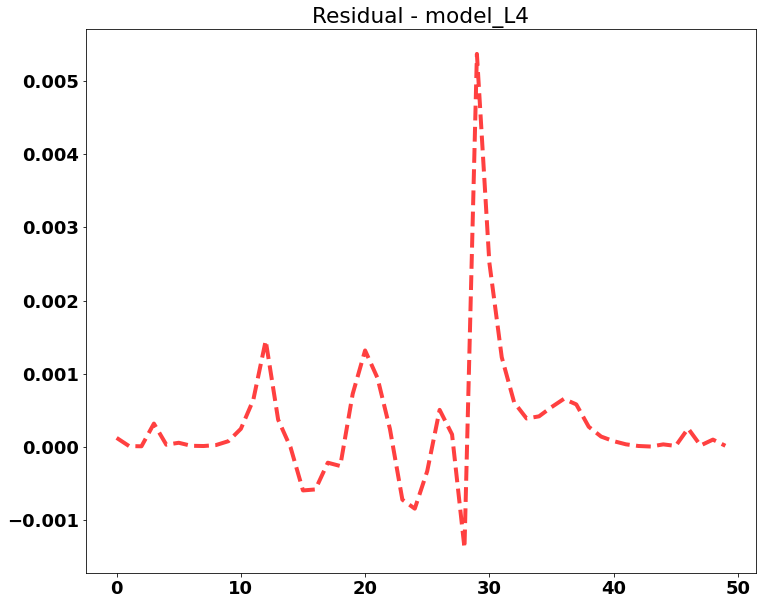

In [7]:
niter=10000 # Number of iterations
verb = True
step_size = 0.1 # step size 
Optim = 3 # Here adagrad is used
LearnFunc = mld.MetricLearning(Params = model,niter=niter,step_size=step_size,Optim=Optim,verb=verb)
outt = LearnFunc.barycentric_span_projection(Xb)

z12,z22 = GetPointImage(outt["Lambda"][0])
plt.figure(figsize=[12,10])
plt.imshow(-20.*np.log10(error)),plt.colorbar()
plt.scatter(z2, z1, s=500, c='red', marker='.')
plt.scatter(z22, z12, s=500, c='blue', marker='x')
plt.title('Optimisation landscape - Cost as a function of the barycentric weights')
plt.xlabel('lambda1')
plt.ylabel('lambda2')
plt.show()

plt.figure(figsize=[12,10])
plt.plot(ampp*Output["X_test"][0:1,:].squeeze(),'r--',lw=4,alpha=0.75)
plt.plot(Xb.squeeze(),lw=6,alpha=0.5)
plt.plot(ampp*Outputt["Xrec"].squeeze(),':',lw=6,alpha=0.8)
plt.plot(outt["Xrec"].squeeze(),lw=4,alpha=0.8)
plt.title('Reconstruction - '+fname)

plt.figure(figsize=[12,10])
plt.plot(ampp*Output["X_test"][0:1,:].squeeze()-outt["Xrec"].squeeze(),'r--',lw=4,alpha=0.75)
plt.title('Residual - '+fname)

